# "Work in Progress: Recreating Fast.ai Chapter 5 Using TensorFlow/Keras"
> "To test my understanding of the [Fast.ai course](https://course.fast.ai/) and to improve my TensorFlow/Keras skills, I am reimplementing chapters of the FastBook in TF/Keras."

- toc: true
- categories: [fastai, tensorflow, keras]

# WIP
This post is currently a **work in progress** and will be progressively updated as I work on it.
- Started: 7/21/21.
- Last updated: 7/24/21.

## TODO
- Normal data aug -> Presizing
- lr Finder
- 1cycle lr
- Discriminative lrs
- Confusion matrix, most confused
- Mixed precision
- Comparison to Fast.ai

# Image Classification

In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import re

In [2]:
# Seed for reproducilbity
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## From Dogs and Cats to Pet Breeds

Let's use `tf.data` API to create datasets. We could have used `tf.keras.preprocessing.image_dataset_from_directory`, but that would have required us to change our file structure where our images are, which I don't really want to do because the Fast.ai lessons depend on it having that file structure.

### Getting Files and Class Codes(?)

In [23]:
path = Path("/home/brandon/.fastai/data/oxford-iiit-pet/images/")

In [24]:
files = list(path.glob(r"*.jpg")); len(files), files[:5]

(7390,
 [PosixPath('/home/brandon/.fastai/data/oxford-iiit-pet/images/Birman_115.jpg'),
  PosixPath('/home/brandon/.fastai/data/oxford-iiit-pet/images/leonberger_142.jpg'),
  PosixPath('/home/brandon/.fastai/data/oxford-iiit-pet/images/Bombay_68.jpg'),
  PosixPath('/home/brandon/.fastai/data/oxford-iiit-pet/images/japanese_chin_26.jpg'),
  PosixPath('/home/brandon/.fastai/data/oxford-iiit-pet/images/saint_bernard_149.jpg')])

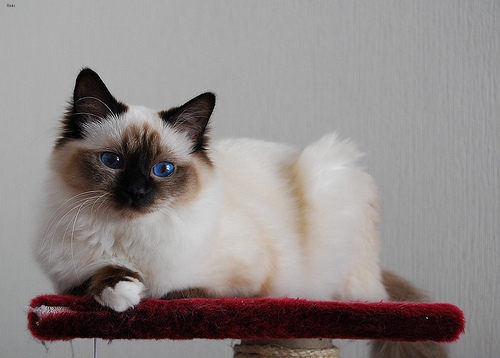

In [25]:
Image.open(files[0])

In [51]:
lbls = [re.findall(f"^(.+)_\d+$", f.stem)[0] for f in files]; len(lbls), lbls[:5]

(7390, ['Birman', 'leonberger', 'Bombay', 'japanese_chin', 'saint_bernard'])

In [54]:
vocab = np.array(sorted(set(lbls))); len(vocab), vocab

(37,
 array(['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
        'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue',
        'Siamese', 'Sphynx', 'american_bulldog',
        'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer',
        'chihuahua', 'english_cocker_spaniel', 'english_setter',
        'german_shorthaired', 'great_pyrenees', 'havanese',
        'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher',
        'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed',
        'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier',
        'wheaten_terrier', 'yorkshire_terrier'], dtype='<U26'))

Awesome, now we're ready to create out `tf.data.Dataset`. We have to convert `Path` objects to strings. This part was analogous to the `get_items` and `get_x` and `get_y` arguments to fastai's `DataBlock`.

In [116]:
data = tf.data.Dataset.from_tensor_slices((list(map(str, files)), lbls)); data, next(iter(data))

(<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 (<tf.Tensor: shape=(), dtype=string, numpy=b'/home/brandon/.fastai/data/oxford-iiit-pet/images/Birman_115.jpg'>,
  <tf.Tensor: shape=(), dtype=string, numpy=b'Birman'>))

Shuffle before splitting val and train. Make sure not to reshuffle each iteration to avoid mixing val and train on different epochs.

In [117]:
data = data.shuffle(len(data), reshuffle_each_iteration=False)

### Splitting into Train and Val

Since our examples are shuffled randomly, we can just take the first 20% of images to be the validation set. The final 80% will be the train set.

In [118]:
num_val = int(len(data) * 0.2)  # 20% for validation set
train_ds, val_ds = data.skip(num_val), data.take(num_val)
len(train_ds), len(val_ds)

(5912, 1478)

In [119]:
# sanity checks
assert len(train_ds) + len(val_ds) == len(data)  # Check no examples were lost
assert not set(f.numpy() for f,lbl in train_ds) & set(f.numpy() for f,lbl in val_ds)  # check that sets are disjoint

### Transform our independent and dependent variables into something we can feed into model

Now we transform our data into something we can feed into our model. This part is analogous to the `DataBlock` API's `item_tfms` and `batch_tfms`. It also will do the role of creating a `DataLoader`. In TensorFlow, there are not separate `Dataset` and `DataLoader` abstractions, your `tf.data.Dataset` object does it all :).

In [120]:
x, y = next(iter(data)); x, y

(<tf.Tensor: shape=(), dtype=string, numpy=b'/home/brandon/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_134.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'american_pit_bull_terrier'>)

**TODO**: Don't hardcode this, pass to dataset getter function

#### Transforms

In [121]:
IMG_SIZE = 224
AUTOTUNE = tf.data.AUTOTUNE

In [122]:
def decode_image(filename):
    """Reads image as tensor and resizes."""
    raw_bytes = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(raw_bytes)
    return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])  # TODO: this changes aspect ratio, experiment w/crop resizing

In [123]:
img = decode_image(x)
assert img.shape[-1] == 3
assert img.dtype == tf.float32

In [124]:
def encode_class(label):
    """Converts class from string tensor -> integer."""
    return tf.argmax(label == vocab)

In [125]:
lbl = encode_class(y)
assert lbl.shape == ()
assert lbl.dtype == tf.int64  # can we encode this as smaller dtype?

In [126]:
def decode_example(filename, label):
    return decode_image(filename), encode_class(label)

In [127]:
train_ds = train_ds.map(decode_example, num_parallel_calls=AUTOTUNE); train_ds

<ParallelMapDataset shapes: ((224, 224, None), ()), types: (tf.float32, tf.int64)>

Doing those were like doing the `item_tfms` of Fast.ai. That read in the image and label as numeric tensors and resized the images all to the same size. Now we'll be able to batch them together.

#### Cache

Now we can cache the extracted images in memory. Since our dataset is small, it will fit in memory. Caching it means we won't have to open up and resize each image each epoch, speeding up our data pipeline.

In [128]:
train_ds = train_ds.cache()

#### Shuffle

We want to shuffle **after** caching. If we shuffled before, then we our images would be presented in the same order each epoch, because they would be loaded from the cache (and not reshuffled) after the first epoch. Note, shuffling maintains all elements in an internal shuffle buffer in memory. So it takes a lot of memory to shuffle the loaded images as they are 3D tensors. It'd take less memory to shuffle the filenames. But then we wouldn't be able to cache the extracted images because then they wouldn't get reshuffled each epoch. So it's a tradeoff between performance and memory. Since our dataset is small, we can fit it all in memory, so we'll use more memory to get the performance boosts.

In [129]:
train_ds = train_ds.shuffle(len(train_ds)); train_ds

<ShuffleDataset shapes: ((224, 224, None), ()), types: (tf.float32, tf.int64)>

#### Batching

Let's batch after shuffling. This will mean that each batch will contain different examples each iteration. If we batched *before* shuffling, then we would just be reordering the batches each epoch, but not actually shuffling examples between batches.

In [130]:
BS = 256
train_ds = train_ds.batch(BS, num_parallel_calls=AUTOTUNE)

#### Prefetch

Lastly, we can prefetch our data. This overlaps our data pipeline and calling our model. So now, as the model is working on a batch of data, our data pipeline is preparing the next batch.

In [131]:
train_ds = train_ds.prefetch(AUTOTUNE)

### Putting it all Together

In [ ]:
def get_datasets()

## Presizing

### Checking and Debugging a DataBlock

## Cross-Entropy Loss

### Viewing Activations and Labels

### Softmax

### Log Likelihood

### Taking the Log

## Model Interpretation

## Improving Our Model

### The Learning Rate Finder

### Unfreezing and Transfer Learning

### Discriminative Learning Rates

### Selecting the Number of Epochs

### Deeper Architectures